# Training a Foreground Segmentation Tool with DINOv3

In this tutorial, we will train a linear foreground segmentation model using DINOv3 features.

### Setup

Let's start by loading some pre-requisites and checking the DINOv3 repository location:
- `local` if `DINOV3_LOCATION` environment variable was set to work with a local version of DINOv3 repository;
- `github` if the code should be loaded via torch hub.

In [1]:
import os
import sys

# Set the path to your checkpoint directory
os.environ['DINOV3_LOCATION'] = '/mmfs1/gscratch/krishna/ardae/dinov3'
 # Repository root '/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/eval/training_24999/sharded_teacher_checkpoint'
# Also set REPO_DIR if needed
REPO_DIR = '/mmfs1/gscratch/krishna/ardae/dinov3'
sys.path.append(REPO_DIR)

In [2]:
import io
import os
import pickle
import tarfile
import urllib

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.transforms.functional as TF
from tqdm import tqdm

DINOV3_GITHUB_LOCATION = "facebookresearch/dinov3"

if os.getenv("DINOV3_LOCATION") is not None:
    DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")
else:
    DINOV3_LOCATION = DINOV3_GITHUB_LOCATION

print(f"DINOv3 location set to {DINOV3_LOCATION}")

DINOv3 location set to /mmfs1/gscratch/krishna/ardae/dinov3


### Model

Let's load the DINOv3 model. For this notebook, we will be using the ViT-L model, but if you have more or less hardware constraints, you can easily load any other DINOv3 model!

In [13]:
# examples of available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

MODEL_NAME = MODEL_DINOV3_VITL

model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="local" if DINOV3_LOCATION != DINOV3_GITHUB_LOCATION else "github",
)
model.cuda()

Downloading: "https://dl.fbaipublicfiles.com/dinov3/dinov3_vitl16/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth" to /mmfs1/home/ardae/.cache/torch/hub/checkpoints/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth


HTTPError: HTTP Error 403: Forbidden

In [4]:
import sys
import torch
import dinov3.distributed as distributed
from dinov3.configs import setup_config, setup_job, DinoV3SetupArgs
from dinov3.models import build_model_for_eval
from pathlib import Path

def load_custom_dinov3_model(
    config_file_path: str,
    checkpoint_path: str,
    output_dir: str = None
):
    """
    Load a custom trained DinoV3 model from sharded checkpoints.
    
    Args:
        config_file_path: Path to the config.yaml file from your training
        checkpoint_path: Path to your sharded checkpoint directory OR teacher_checkpoint.pth file
        output_dir: Output directory (can be None for inference)
    
    Returns:
        model: Loaded DinoV3 model ready for inference
    """
    
    # Initialize distributed training for single GPU (required for DinoV3)
    #setup_job(output_dir=output_dir, distributed_enabled=True)
    
    # Set up configuration
    setup_args = DinoV3SetupArgs(
        config_file=config_file_path,
        pretrained_weights=checkpoint_path,
        output_dir=output_dir or "."
    )
    
    config = setup_config(setup_args, strict_cfg=False)
    
    # Build and load the model
    model = build_model_for_eval(config, setup_args.pretrained_weights)
    model.cuda()
    model.eval()
    
    return model

# Example usage for your specific case:
# Replace these paths with your actual paths
CONFIG_FILE = "/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/config.yaml"

# Option 1: If you have a sharded checkpoint directory (from training checkpoints)
CHECKPOINT_DIR = "/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/eval/training_87499/sharded_teacher_checkpoint"

# Option 2: If you have a consolidated teacher checkpoint file
# CHECKPOINT_FILE = "/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/eval/training_24999/teacher_checkpoint.pth"

# Load your custom model
model = load_custom_dinov3_model(
    config_file_path=CONFIG_FILE,
    checkpoint_path=CHECKPOINT_DIR,  # or CHECKPOINT_FILE
    output_dir=None
)

print("Model loaded successfully!")
print(f"Model architecture: {model}")

# Now you can use this model in place of the standard DinoV3 model
# in the foreground segmentation notebook

# Example: Extract features from an image
def extract_features(model, image_tensor):
    """
    Extract DinoV3 features from an image tensor.
    
    Args:
        model: Loaded DinoV3 model
        image_tensor: Image tensor of shape (1, 3, H, W)
    
    Returns:
        features: Extracted features
    """
    with torch.no_grad():
        features = model.forward_features(image_tensor)
        return features

# Example usage:
# image_tensor = torch.randn(1, 3, 224, 224).cuda()  # Example input
# features = extract_features(model, image_tensor)

DinoV3SetupArgs(config_file='/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/config.yaml', pretrained_weights='/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/eval/training_87499/sharded_teacher_checkpoint', shard_unsharded_model=False, output_dir='.', opts=[])
config file:
/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/config.yaml
DinoV3SetupArgs(config_file='/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/config.yaml', pretrained_weights='/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/eval/training_87499/sharded_teacher_checkpoint', shard_unsharded_model=False, output_dir='.', opts=[])


AssertionError: Setup distributed to get global size !

In [12]:
import os
import sys
import torch
from pathlib import Path

def load_dinov3_interactive_session(config_file_path, checkpoint_path, output_dir=None):
    """
    Load DinoV3 model optimized for interactive SLURM sessions.
    
    Interactive sessions often have incomplete SLURM environment variables,
    so we temporarily switch to manual mode for the setup.
    """
    print("🔄 Loading DinoV3 in interactive session mode...")
    
    # Check if we're in an interactive session
    is_interactive = (
        os.environ.get('SLURM_JOB_ID') and 
        not os.environ.get('SLURM_JOB_NUM_NODES')  # Missing in interactive
    )
    
    if is_interactive:
        print("✅ Detected interactive SLURM session")
    else:
        print("ℹ️ Not detected as interactive session, using standard approach")
    
    # Backup SLURM variables that cause issues in interactive sessions
    slurm_backup = {}
    problematic_vars = ['SLURM_JOB_ID']  # Just this one is enough to switch modes
    
    for var in problematic_vars:
        if var in os.environ:
            slurm_backup[var] = os.environ[var]
            del os.environ[var]
            print(f"  Temporarily hiding {var}")
    
    try:
        # Now DinoV3 will use MANUAL mode instead of SLURM mode
        from dinov3.configs import setup_config, setup_job, DinoV3SetupArgs
        from dinov3.models import build_model_for_eval
        
        # Setup job in manual mode (single GPU, local)
        #setup_job(output_dir=output_dir, distributed_enabled=True) #Run once
        print("✅ Distributed setup completed in manual mode")
        
        # Configure model
        setup_args = DinoV3SetupArgs(
            config_file=config_file_path,
            pretrained_weights=checkpoint_path,
            output_dir=output_dir or "."
        )
        
        print("🔄 Loading configuration...")
        config = setup_config(setup_args, strict_cfg=False)
        
        print("🔄 Building and loading model...")
        model = build_model_for_eval(config, setup_args.pretrained_weights)
        model.cuda()
        model.eval()
        
        print("✅ Model loaded successfully!")
        return model
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None
        
    finally:
        # Restore SLURM environment variables
        for var, value in slurm_backup.items():
            os.environ[var] = value
            print(f"  Restored {var}")

def test_model(model):
    """Quick test to make sure the model works"""
    print("🧪 Testing model...")
    try:
        # Test with a dummy input
        test_input = torch.randn(1, 3, 224, 224).cuda()
        with torch.no_grad():
            features = model.forward_features(test_input)
        
        if hasattr(features, 'shape'):
            print(f"✅ Model test passed! Features shape: {features.shape}")
        else:
            print(f"✅ Model test passed! Features type: {type(features)}")
        return True
    except Exception as e:
        print(f"❌ Model test failed: {e}")
        return False

# Main usage - replace your current code with this:
if __name__ == "__main__":
    # Your file paths
    CONFIG_FILE = "/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/config.yaml"
    CHECKPOINT_DIR = "/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/eval/training_149999/teacher_checkpoint.pth"
    
    # Load the model
    model = load_dinov3_interactive_session(CONFIG_FILE, CHECKPOINT_DIR)
    
    if model:
        print("🎉 SUCCESS! Model is ready.")
        
        # Test it
        if test_model(model):
            print("🎯 Your model is working perfectly!")
            print("\nYou can now use it for foreground segmentation:")
            print("• model.forward_features(image_tensor) - extract features")
            print("• The model works exactly like standard DinoV3 models")
        
        # Example feature extraction function
        def extract_features(image_tensor):
            """Extract DinoV3 features from image tensor (1, 3, H, W)"""
            with torch.no_grad():
                return model.forward_features(image_tensor)
        
        print(f"\n📝 Model loaded and ready!")
        print(f"   Type: {type(model)}")
        print(f"   Device: {'CUDA' if next(model.parameters()).is_cuda else 'CPU'}")
    else:
        print("😞 Failed to load model.")

# For use in notebooks, just call:
# model = load_dinov3_interactive_session(CONFIG_FILE, CHECKPOINT_DIR)

🔄 Loading DinoV3 in interactive session mode...
✅ Detected interactive SLURM session
  Temporarily hiding SLURM_JOB_ID
✅ Distributed setup completed in manual mode
🔄 Loading configuration...
DinoV3SetupArgs(config_file='/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/config.yaml', pretrained_weights='/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/eval/training_149999/teacher_checkpoint.pth', shard_unsharded_model=False, output_dir='.', opts=[])
config file:
/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/config.yaml
DinoV3SetupArgs(config_file='/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/config.yaml', pretrained_weights='/mmfs1/gscratch/krishna/ardae/dinov3/mmfs1/gscratch/krishna/ardae/dinov3/experiments/eval/training_149999/teacher_checkpoint.pth', shard_unsharded_model=False, output_dir='.', opts=[])
I20250926 12:26:05 11582 dinov3 c

I20250926 12:26:06 11582 dinov3 checkpointer.py:310] Take key teacher in provided checkpoint dict
❌ Error loading model: Error(s) in loading state_dict for DinoVisionTransformer:
	While copying the parameter named "cls_token", whose dimensions in the model are torch.Size([1, 1, 1024]) and whose dimensions in the checkpoint are torch.Size([1, 1, 1024]), an exception occurred : ('CUDA error: an illegal instruction was encountered\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n',).
	While copying the parameter named "mask_token", whose dimensions in the model are torch.Size([1, 1024]) and whose dimensions in the checkpoint are torch.Size([1, 1024]), an exception occurred : ('CUDA error: an illegal instruction was encountered\nCUDA kernel errors might be asynchronously reported at some other AP

### Data
Now that we have the model set up, let's load the training data. It consists of:

- images in `jpg` format:
```
https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_images.tar.gz
```

- and segmentation masks stored as alpha channels in `png` files:
```
https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_labels.tar.gz
```

In total, there are 9 training image / mask pairs.


In [5]:
IMAGES_URI = "https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_images.tar.gz"
LABELS_URI = "https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_labels.tar.gz"

def load_images_from_remote_tar(tar_uri: str) -> list[Image.Image]:
    images = []
    with urllib.request.urlopen(tar_uri) as f:
        tar = tarfile.open(fileobj=io.BytesIO(f.read()))
        for member in tar.getmembers():
            image_data = tar.extractfile(member)
            image = Image.open(image_data)
            images.append(image)
    return images
    
images = load_images_from_remote_tar(IMAGES_URI)
labels = load_images_from_remote_tar(LABELS_URI)
n_images = len(images)
assert n_images == len(labels), f"{len(images)=}, {len(labels)=}"

print(f"Loaded {n_images} images and labels")

Loaded 9 images and labels


Let's, for example, visualize the first image / mask pair:

Showing image / mask at index 0:


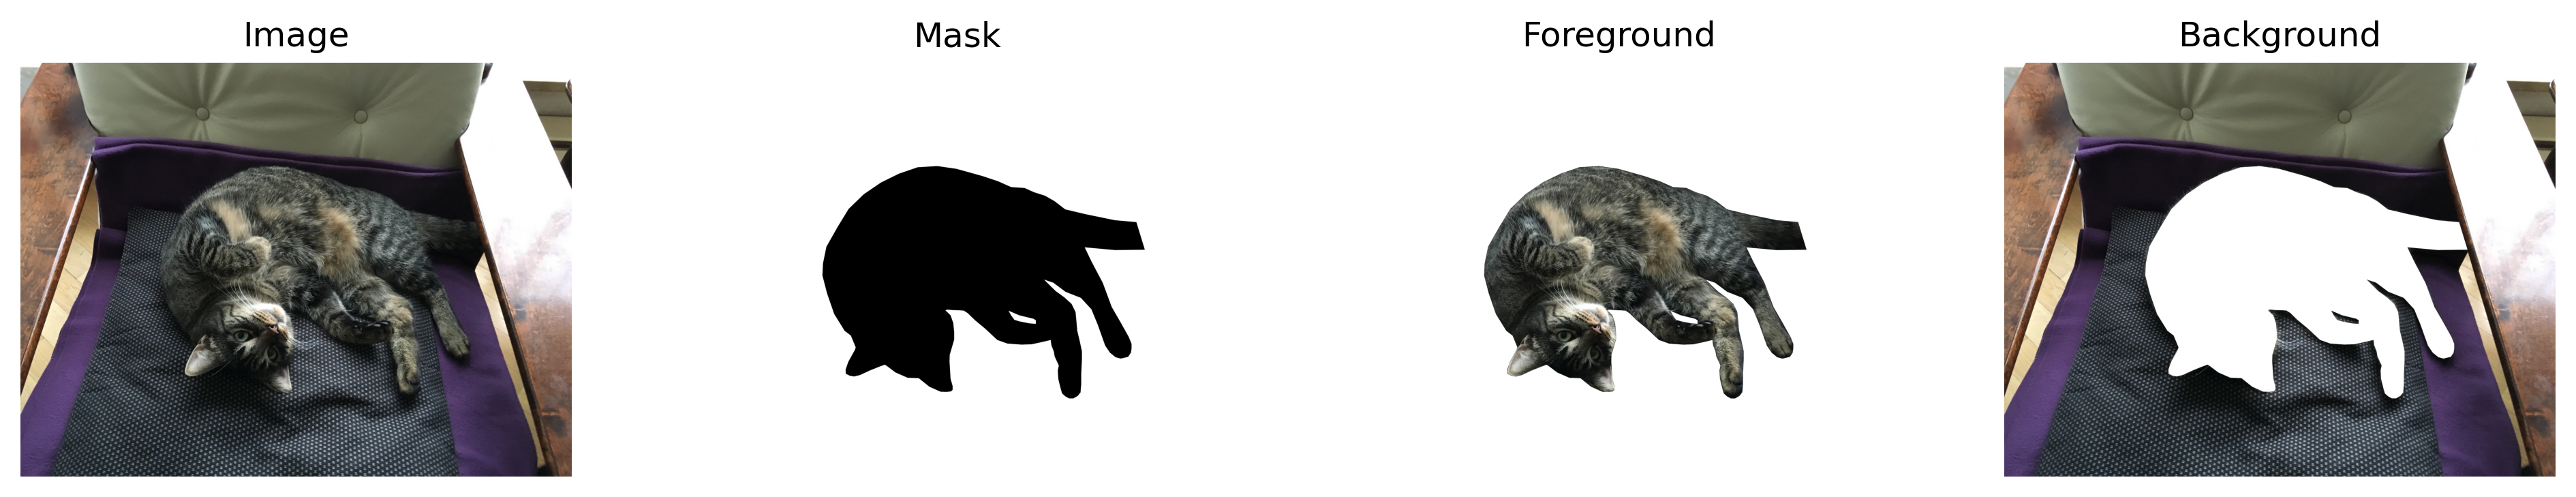

In [6]:
data_index = 0

print(f"Showing image / mask at index {data_index}:")

image = images[data_index]
mask = labels[data_index]
foreground = Image.composite(image, mask, mask)
mask_bg_np = np.copy(np.array(mask))
mask_bg_np[:, :, 3] = 255 - mask_bg_np[:, :, 3]
mask_bg = Image.fromarray(mask_bg_np)
background = Image.composite(image, mask_bg, mask_bg)

data_to_show = [image, mask, foreground, background]
data_labels = ["Image", "Mask", "Foreground", "Background"]

plt.figure(figsize=(16, 4), dpi=300)
for i in range(len(data_to_show)):
    plt.subplot(1, len(data_to_show), i + 1)
    plt.imshow(data_to_show[i])
    plt.axis('off')
    plt.title(data_labels[i], fontsize=12)
plt.show()

### Building Per-Patch Label Map

Since our models run with a patch size of 16, we have to quantize the ground truth to a 16x16 pixels grid. To achieve this, we define:
- the resize transform to resize an image such that it aligns well with the 16x16 grid;
- a uniform 16x16 conv layer as a [box blur filter](https://en.wikipedia.org/wiki/Box_blur) with stride equal to the patch size.

In [7]:
PATCH_SIZE = 16
IMAGE_SIZE = 768

# quantization filter for the given patch size
patch_quant_filter = torch.nn.Conv2d(1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False)
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))

# image resize transform to dimensions divisible by patch size
def resize_transform(
    mask_image: Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))

Let's, for example, visualize the first mask before and after quantization:

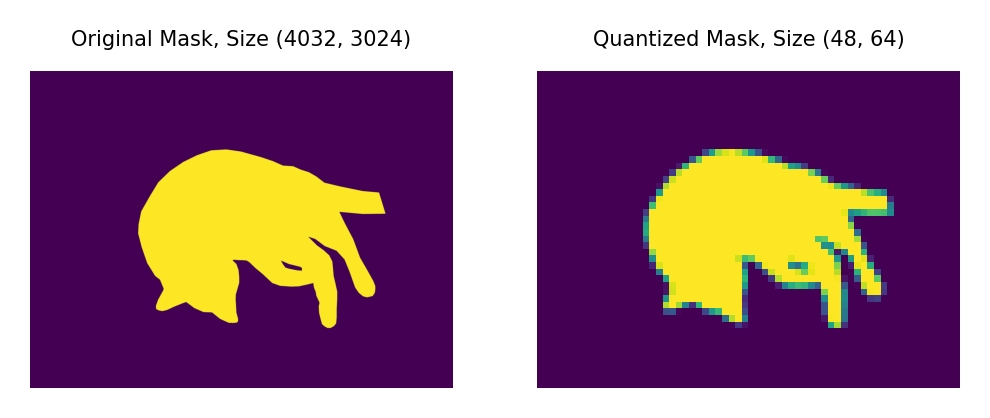

In [8]:
mask_0 = labels[0].split()[-1]
mask_0_resized = resize_transform(mask_0)
with torch.no_grad():
    mask_0_quantized = patch_quant_filter(mask_0_resized).squeeze().detach().cpu()

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(mask_0)
plt.axis('off')
plt.title(f"Original Mask, Size {mask_0.size}", fontsize=5)
plt.subplot(1, 2, 2)
plt.imshow(mask_0_quantized)
plt.axis('off')
plt.title(f"Quantized Mask, Size {tuple(mask_0_quantized.shape)}", fontsize=5)
plt.show()

### Extracting Features and Labels for All the Images
Now we will loop over the 9 training images, and extract for each image the patch labels, as well as the patch features. That involves running the dense feature extraction of our model with :

```
with torch.no_grad():        
    feats = model.get_intermediate_layers(img, n=range(n_layers), reshape=True, norm=True)
    dim = feats[-1].shape[1]
    xs.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())
```

In [10]:
xs = []
ys = []
image_index = []

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

#MODEL_TO_NUM_LAYERS = {
#    MODEL_DINOV3_VITS: 12,
#   MODEL_DINOV3_VITSP: 12,
#    MODEL_DINOV3_VITB: 12,
#    MODEL_DINOV3_VITL: 24,
#    MODEL_DINOV3_VITHP: 32,
#    MODEL_DINOV3_VIT7B: 40,
#}

n_layers = 24

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        for i in tqdm(range(n_images), desc="Processing images"):
            # Loading the ground truth
            mask_i = labels[i].split()[-1]
            mask_i_resized = resize_transform(mask_i)
            mask_i_quantized = patch_quant_filter(mask_i_resized).squeeze().view(-1).detach().cpu()
            ys.append(mask_i_quantized)
            # Loading the image data 
            image_i = images[i].convert('RGB')
            image_i_resized = resize_transform(image_i)
            image_i_resized = TF.normalize(image_i_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
            image_i_resized = image_i_resized.unsqueeze(0).cuda()

            feats = model.get_intermediate_layers(image_i_resized, n=range(n_layers), reshape=True, norm=True)
            dim = feats[-1].shape[1]
            xs.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())

            image_index.append(i * torch.ones(ys[-1].shape))


# Concatenate all lists into torch tensors 
xs = torch.cat(xs)
ys = torch.cat(ys)
image_index = torch.cat(image_index)

# keeping only the patches that have clear positive or negative label
idx = (ys < 0.01) | (ys > 0.99)
xs = xs[idx]
ys = ys[idx]
image_index = image_index[idx]

print("Design matrix of size : ", xs.shape)
print("Label matrix of size : ", ys.shape)

Processing images:   0%|          | 0/9 [00:00<?, ?it/s]

Processing images:   0%|          | 0/9 [00:00<?, ?it/s]


AcceleratorError: CUDA error: an illegal instruction was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Training a Classifier and Model Selection
We computed the features, let's now train a classifier! Our data is very strongly correlated image-by-image. Therefore, to do proper model selection, we can't simply split the data in an IID way. We need to do something a bit smarter. We will do leave-one-out, and consecutively exclude each image as a validation set. 
We'll try 8 values of C ranging from 1e-7 to 1e-0. 

For each value of C and each image, we plot the precision-recall curve of the classifier, and report the mAP (area under the PR curve).

validation using image_01.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


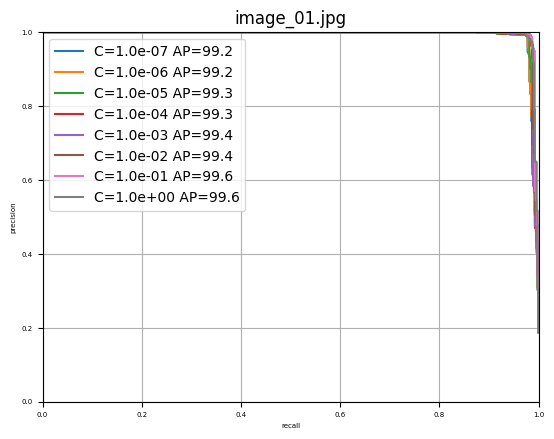

validation using image_02.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


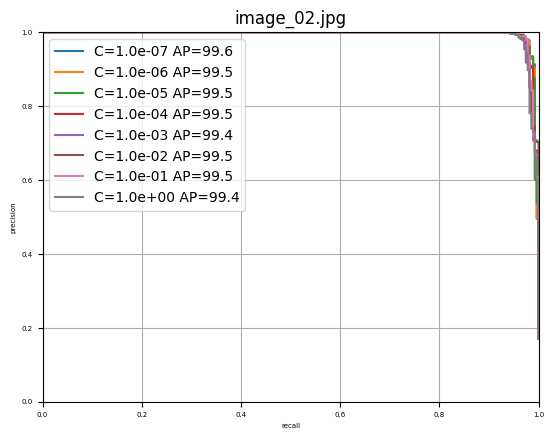

validation using image_03.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


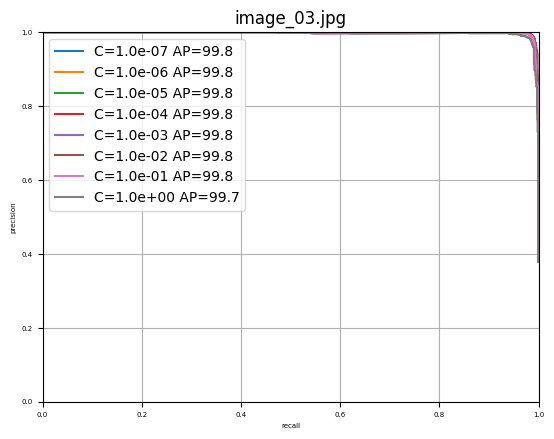

validation using image_04.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


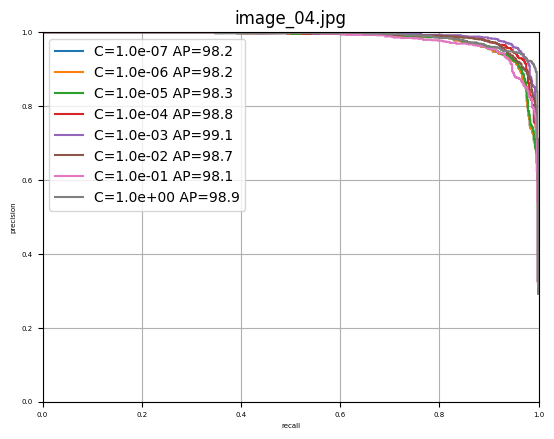

validation using image_05.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


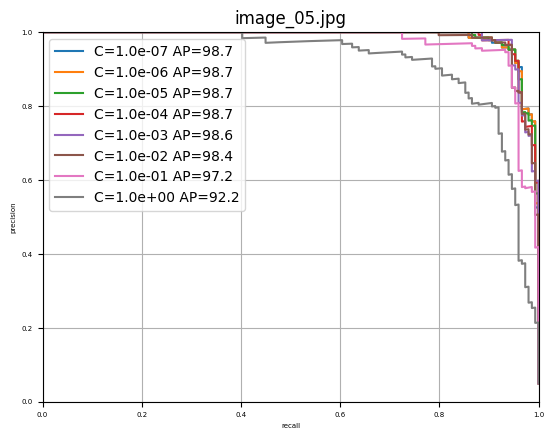

validation using image_06.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


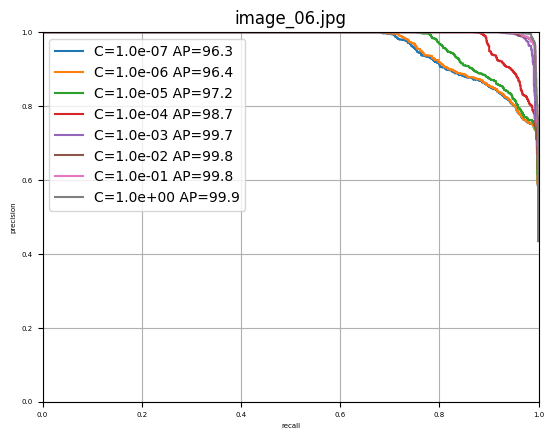

validation using image_07.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


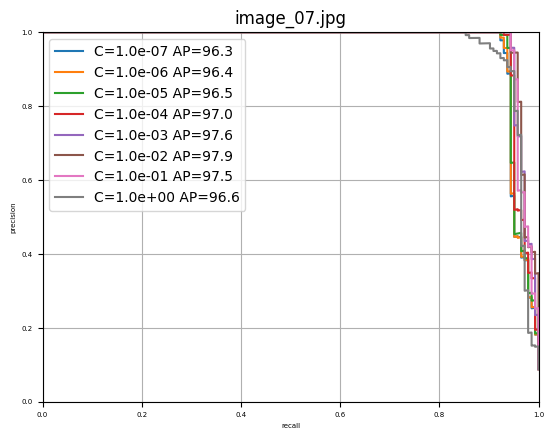

validation using image_08.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


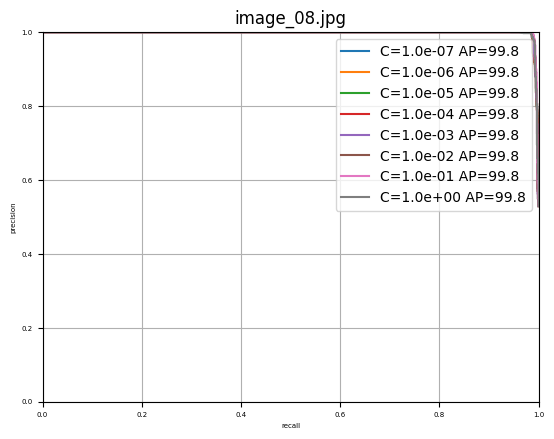

validation using image_09.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


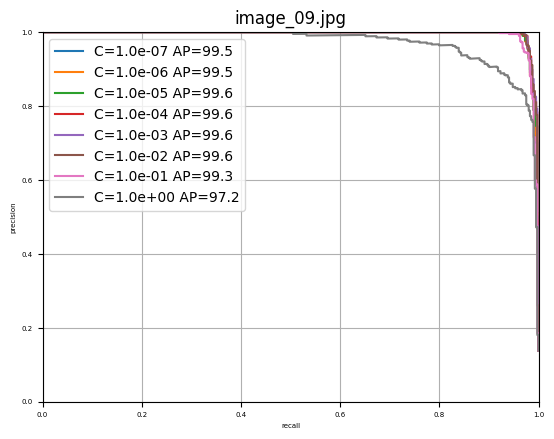

In [71]:
cs = np.logspace(-7, 0, 8)
scores = np.zeros((n_images, len(cs)))

for i in range(n_images):
    # We use leave-one-out so train will be all but image i, val will be image i
    print('validation using image_{:02d}.jpg'.format(i+1))
    train_selection = image_index != float(i)
    fold_x = xs[train_selection].numpy()
    fold_y = (ys[train_selection] > 0).long().numpy()
    val_x = xs[~train_selection].numpy()
    val_y = (ys[~train_selection] > 0).long().numpy()

    plt.figure()
    for j, c in enumerate(cs):
        print("training logisitic regression with C={:.2e}".format(c))
        clf = LogisticRegression(random_state=0, C=c, max_iter=10000).fit(fold_x, fold_y)
        output = clf.predict_proba(val_x)
        precision, recall, thresholds = precision_recall_curve(val_y, output[:, 1])
        s = average_precision_score(val_y, output[:, 1])
        scores[i, j] = s
        plt.plot(recall, precision, label='C={:.1e} AP={:.1f}'.format(c, s*100))

    plt.grid()
    plt.xlabel('recall')
    plt.title('image_{:02d}.jpg'.format(i+1))
    plt.ylabel('precision')
    plt.axis([0, 1, 0, 1])
    plt.legend()
    plt.show()


### Choosing the Best C
Now, let's have a look at which value of C works best on average. To this end we will plot the average mAP across all validation images.

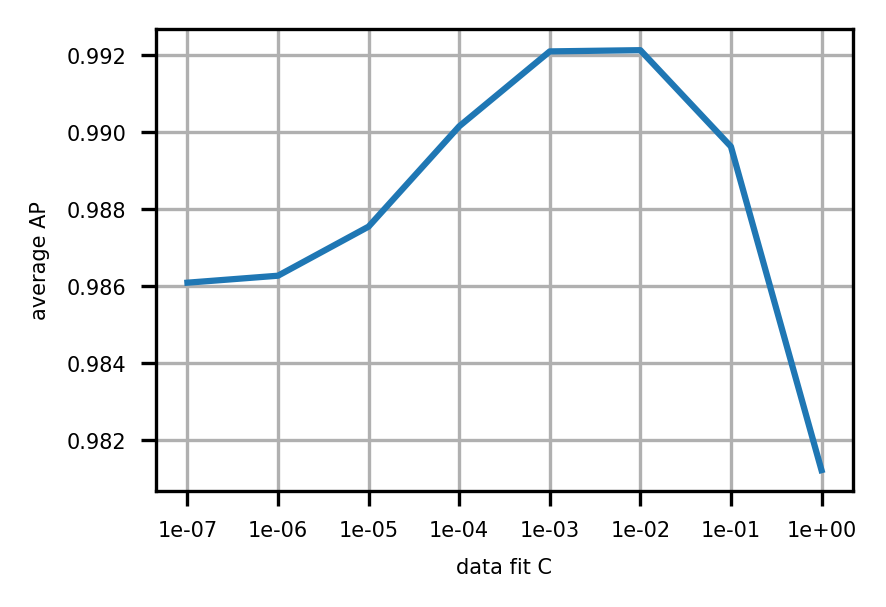

In [72]:
plt.figure(figsize=(3, 2), dpi=300)
plt.rcParams.update({
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "axes.labelsize": 5,
})
plt.plot(scores.mean(axis=0))
plt.xticks(np.arange(len(cs)), ["{:.0e}".format(c) for c in cs])
plt.xlabel('data fit C')
plt.ylabel('average AP')
plt.grid()
plt.show()

### Retraining with the optimal regularization
Given the above, we seem to have a winner: C=0.1. 
Let's now train a model using this optimal data-fit value. 

In [73]:
clf = LogisticRegression(random_state=0, C=0.1, max_iter=100000, verbose=2).fit(xs.numpy(), (ys > 0).long().numpy())

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished


### Test Images and Inference 

We have a classifier, now it is time to test it! We will predict the probability of patch being foreground given an image, and then process it with a 3x3 median filter to smooth it out.

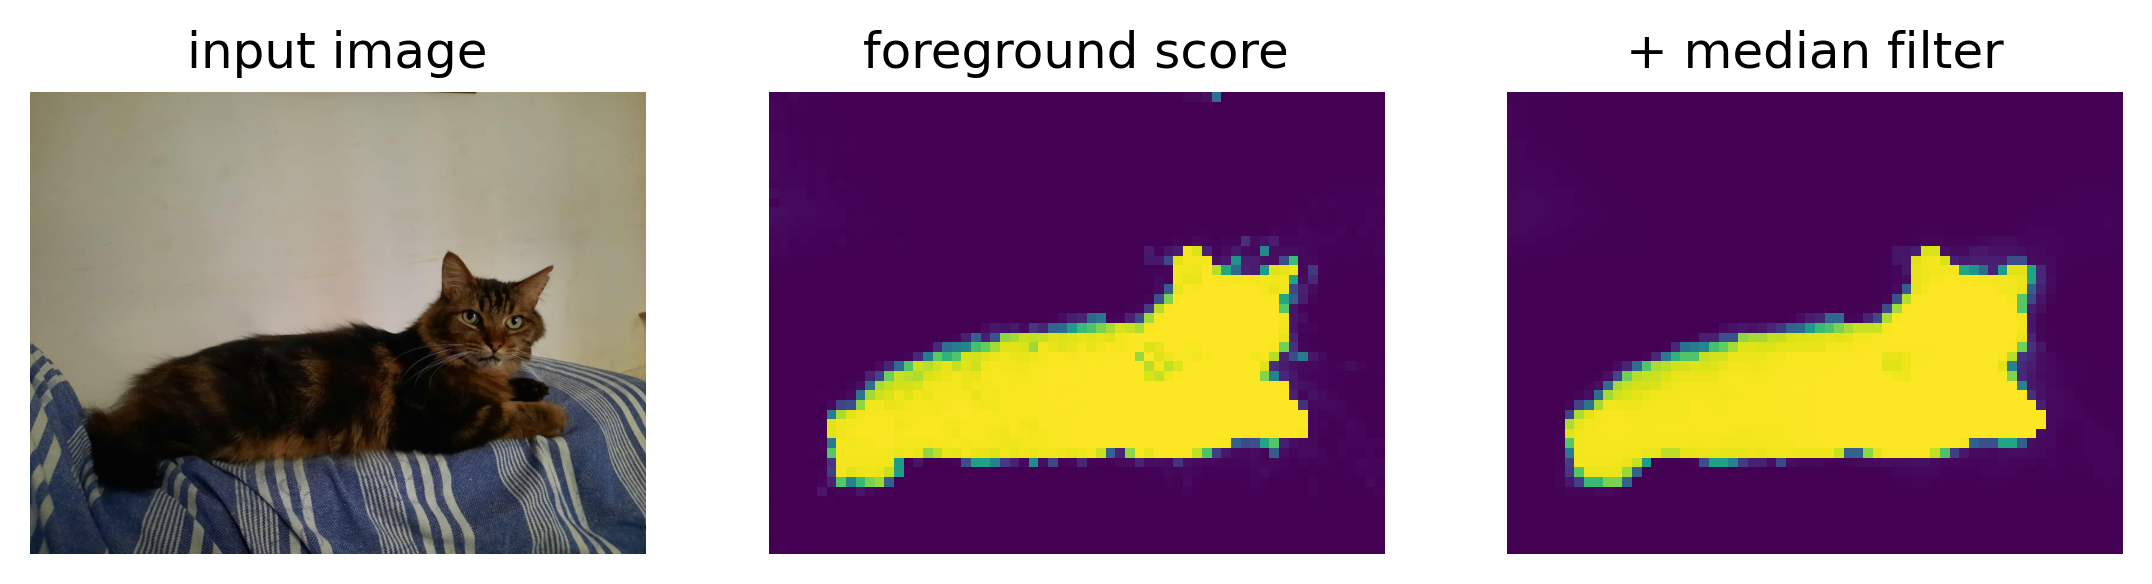

In [74]:
test_image_fpath = "https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/test_image.jpg"

def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


test_image = load_image_from_url(test_image_fpath)
test_image_resized = resize_transform(test_image)
test_image_normalized = TF.normalize(test_image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        feats = model.get_intermediate_layers(test_image_normalized.unsqueeze(0).cuda(), n=range(n_layers), reshape=True, norm=True)
        x = feats[-1].squeeze().detach().cpu()
        dim = x.shape[0]
        x = x.view(dim, -1).permute(1, 0)

h_patches, w_patches = [int(d / PATCH_SIZE) for d in test_image_resized.shape[1:]]

fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))

plt.figure(figsize=(9, 3), dpi=300)
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(test_image_resized.permute(1, 2, 0))
plt.title('input image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(fg_score)
plt.title('foreground score')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(fg_score_mf)
plt.title('+ median filter')
plt.show()

### Saving the Model for Future Use
We are nearly done, let's just save a pickle with the classifier.


In [ ]:
save_root = '/mmfs1/gscratch/krishna/ardae/dinov3/notebooks/classifiers'
model_path = os.path.join(save_root, "fg_classifier150k.pkl")
with open(model_path, "wb") as f:
  pickle.dump(clf, f)